# © Artur Czarnecki. All rights reserved.
# Integrax framework – proprietary and confidential.
# Use, modification, or distribution without written permission is prohibited.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

# Web Research Agent (Intergrax WebSearch + LangGraph)

This notebook demonstrates a **practical web research agent** built from:

- **Intergrax** components:
  - `WebSearchExecutor` – orchestrates web search providers (Google, Bing, Reddit, etc.).
  - `WebSearchContextBuilder` – builds a compact textual context + citations.
  - `WebSearchAnswerer` – uses an LLM adapter to answer strictly from the web context.
- **LangGraph**:
  - orchestrates the flow as a multi-step graph:
    1. Normalize the user question.
    2. Run web search.
    3. Build context.
    4. Generate a final answer with sources.

This is a realistic example of how Intergrax can power **“no-hallucination” web-based Q&A** inside a graph-based agent.


In [2]:
from typing import TypedDict, List, Dict, Any, Optional

from langgraph.graph import StateGraph, END

from openai import Client
import os

from intergrax.llm_adapters import OpenAIChatResponsesAdapter
from intergrax.websearch.service.websearch_executor import WebSearchExecutor
from intergrax.websearch.context.websearch_context_builder import WebSearchContextBuilder
from intergrax.websearch.service.websearch_answerer import WebSearchAnswerer
from intergrax.websearch.schemas.web_document import WebDocument
from intergrax.websearch.providers.google_cse_provider import GoogleCSEProvider

from dotenv import load_dotenv

load_dotenv()

True

# Initialize LLM adapter and WebSearch components

In [3]:
# Ensure your OpenAI key is in the environment
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", "")
os.environ["GOOGLE_CSE_API_KEY"] = os.getenv("GOOGLE_CSE_API_KEY")
os.environ["GOOGLE_CSE_CX"] = os.getenv("GOOGLE_CSE_CX")

openai_client = Client()

# Intergrax LLM adapter (used internally by WebSearchAnswerer)
llm_adapter = OpenAIChatResponsesAdapter(
    client=openai_client,
    model="gpt-5-mini",  # adjust to your preferred model
)

# WebSearch executor – adjust constructor to match your implementation.
# If your executor takes providers explicitly, pass them here
# (e.g. GoogleCSEProvider, BingWebProvider, RedditProvider, etc.).
websearch_executor = WebSearchExecutor(
    providers=[GoogleCSEProvider()],
    default_top_k=6,
    default_locale="en-US",
    default_region="en-US",
    default_language="en",
    default_safe_search=True,
    max_text_chars=2000,
)

# Context builder and answerer
context_builder = WebSearchContextBuilder(
    max_docs=4,
    max_chars_per_doc=1500,
    include_snippet=True,
    include_url=True,
    source_label_prefix="Source",
)

websearch_answerer = WebSearchAnswerer(
    adapter=llm_adapter,
    executor=websearch_executor,
    context_builder=context_builder,
    answer_language="en",
    # system_prompt=system_prompts.strict_web_rag,  # optional, if you have it
)

# Define the graph state

In [4]:
class WebResearchState(TypedDict):
    """
    Graph state for the Web Research Agent.

    Fields:
      - user_question: original question entered by the user.
      - normalized_question: cleaned / normalized question used for search.
      - search_results: list of documents returned by web search.
      - context_text: condensed textual context built from the search results.
      - citations: list of structured citations (urls, titles, snippets, etc.).
      - answer: final answer generated by the LLM.
    """
    user_question: str
    normalized_question: str
    search_results: List[Dict[str, Any]]
    context_text: str
    citations: List[Dict[str, Any]]
    answer: str


# Node: normalize user question

In [5]:
def parse_user_query_node(state: WebResearchState) -> WebResearchState:
    """
    Node: normalize the user question.

    In this basic version we just strip whitespace and reuse the original text.
    In a more advanced version, this node could:
      - detect language,
      - rewrite the query for better search recall,
      - classify intent (e.g., "comparison", "how-to", "definition").
    """
    question = state["user_question"].strip()

    return {
        "normalized_question": question
    }


# Node: run web search

In [6]:
from typing import List, Dict, Any


async def websearch_node(state: WebResearchState) -> WebResearchState:
    """
    Node: execute web search using Intergrax WebSearchExecutor.

    We use the existing async API:

        WebSearchExecutor.search_async(
            query=...,
            top_k=...,
            serialize=True,
        )

    With `serialize=True` the executor returns a list of plain dictionaries
    ready to be consumed by `WebSearchContextBuilder.build_context_from_serialized(...)`.
    """
    query = state["normalized_question"]

    # Call the async executor method – LangGraph supports async nodes.
    web_docs: List[Dict[str, Any]] = await websearch_executor.search_async(
        query=query,
        top_k=8,       # or some default like 8/10, up to you
        serialize=True,   # we want serialized dicts, not WebDocument objects
    )

    # Here we already have list[dict], so no extra to_dict / conversion is needed.
    return {
        "search_results": web_docs
    }


# Node: build context from search results

In [7]:
def build_context_node(state: WebResearchState) -> WebResearchState:
    """
    Node: build a condensed textual context string and a list of citations
    from serialized web search results.

    Uses the existing Intergrax component:

      - WebSearchContextBuilder.build_context_from_serialized(web_docs)

    and then derives a simple `citations` list from the same docs.
    """
    # Serialized web documents from the previous node
    docs = state.get("search_results", [])

    # Use your existing builder method (no generic .build())
    context_text = context_builder.build_context_from_serialized(docs)

    # Build simple citation metadata (for printing sources later)
    citations: List[Dict[str, Any]] = []
    # Respect the same max_docs as the context builder
    max_docs = getattr(context_builder, "max_docs", len(docs))

    for idx, doc in enumerate(docs[:max_docs], start=1):
        citations.append(
            {
                "label": f"{context_builder.source_label_prefix} {idx}",
                "title": str(doc.get("title") or "").strip() or "(no title)",
                "url": str(doc.get("url") or "").strip(),
                "snippet": str(doc.get("snippet") or "").strip(),
            }
        )

    return {
        "context_text": context_text,
        "citations": citations,
    }


# Node: generate final answer from context

In [ ]:
from intergrax.llm.messages import ChatMessage  # adjust if needed


def web_llm_answer_node(state: WebResearchState) -> WebResearchState:
    """
    Node: generate the final answer using the LLM adapter and web context.

    This node:
      1) Uses `context_builder.build_messages_from_serialized(...)` to create
         a strict system+user prompt based on the web sources.
      2) Wraps them into Intergrax `ChatMessage` objects.
      3) Calls `llm_adapter.generate_messages(...)` to get the final answer.

    We *do not* use `WebSearchAnswerer` here, because in this graph we already
    ran WebSearchExecutor and built the context in previous nodes.
    """
    question = state["normalized_question"]
    search_results = state.get("search_results", [])

    # 1) Build system+user messages dicts from the serialized web docs
    msg_dicts = context_builder.build_messages_from_serialized(
        user_question=question,
        web_docs=search_results,
        answer_language="en",          # or "en" – up to you
        # system_prompt_override="...",  # optional if you want a custom system prompt
    )

    # 2) Convert dicts to ChatMessage objects for the adapter
    messages = [
        ChatMessage(role=m["role"], content=m["content"])
        for m in msg_dicts
    ]

    # 3) Call the Intergrax LLM adapter
    answer_text = llm_adapter.generate_messages(
        messages,
        temperature=0.2,
        max_tokens=None,
    )

    # 4) Reuse citations from the context-building node
    citations = state.get("citations", [])

    return {
        "answer": answer_text,
        "citations": citations,
    }


# Build the LangGraph graph

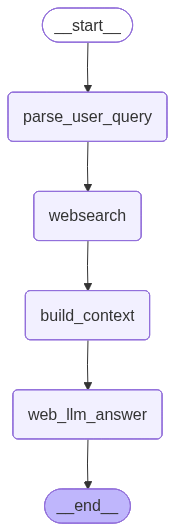

In [9]:
from IPython.display import Image, display

# Build the graph for WebResearchState
web_graph_builder = StateGraph(WebResearchState)

# Register nodes
web_graph_builder.add_node("parse_user_query", parse_user_query_node)
web_graph_builder.add_node("websearch", websearch_node)
web_graph_builder.add_node("build_context", build_context_node)
web_graph_builder.add_node("web_llm_answer", web_llm_answer_node)

# Define flow
web_graph_builder.set_entry_point("parse_user_query")
web_graph_builder.add_edge("parse_user_query", "websearch")
web_graph_builder.add_edge("websearch", "build_context")
web_graph_builder.add_edge("build_context", "web_llm_answer")
web_graph_builder.add_edge("web_llm_answer", END)

# Compile into an executable graph
web_research_graph = web_graph_builder.compile()

display(Image(web_research_graph.get_graph().draw_mermaid_png()))

# Run a practical research query

In [10]:
initial_web_state: WebResearchState = {
    "user_question": (
        "Compare LangGraph and LangChain for building production LLM agents. "
        "Explain the main differences in architecture, typical use cases, and trade-offs. "
        "Provide a concise summary with references to concrete sources."
    ),
    "normalized_question": "",
    "search_results": [],
    "context_text": "",
    "citations": [],
    "answer": "",
}

result = await web_research_graph.ainvoke(initial_web_state)

print("=== ANSWER ===\n")
print(result["answer"])

print("\n=== SOURCES / CITATIONS ===")
for idx, c in enumerate(result.get("citations", []), start=1):
    url = c.get("url") or c.get("link") or c.get("source") or "N/A"
    title = c.get("title") or "Untitled"
    print(f"{idx}. {title} - {url}")


=== ANSWER ===

- Architecture: LangChain is described as “the basic bricks and instructions (the standard framework for chaining LLM calls)” — i.e., a framework for composing LLM-call chains [Source 3]. LangGraph is described as building on that idea by providing “advanced connectors and logic to build more dynamic workflows (handling state and branching)” [Source 3].

- Typical use cases: use LangChain for standard LLM call chaining and simple composed pipelines; use LangGraph when you need dynamic workflows, explicit state handling, or branching agent logic [Source 3].

- Trade‑offs and production considerations: the provided sources do not give a direct, tool-to-tool comparison of production trade‑offs (latency, cost, reliability, scalability, or deployment details) between LangChain and LangGraph — those specifics are not stated. The broader literature on LLM/agent applications notes general challenges to consider for agent systems (protocol fragmentation, security risks in open a